# Energy Consumption Reduction Prediction Challenge: A Real-World Trial Analysis

In [54]:
# Import libraries
import glob
# import pickle
import warnings
# import itertools
from typing import List, Tuple, Dict, Set, Optional, Union 
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# SOME CONSTANTS
PROCESSED_DATA_PATH = "../data/processed"
RAW_DATA_PATH = "../data/raw"

# Import Data

Data wrangling function
- [x] load data, check shape and global info
- [x] variables type:
  - [x] integer or float
  - [x] string normalization (strip, case), 
  - [x] boolean normalization (true, false -> True, False)
  - [x] date normalization
  - [x] Normalize missing values indicator ()
- [x] missing values
  - [x] Missing rates (delete "high" missing values rate columns)
  - [-] Potential causes (MCAR, MAR, NMAR / Random, Direct, Indirect, Hybrid), (https://cremilleux.users.greyc.fr/papers/dawak09final.pdf)
- [ ] outliers ? (what does it mean)
- [-] low- and high-cardinality variables (recoding suggestion?)
- [-] leakage variables (w.r.t. the modelization objective)

In [3]:
def load_data(data_rootpath: str) -> pd.DataFrame:
    """
    Load data from CSV files in the specified directory and merge them.

    Args:
        data_rootpath (str): The root path of the data files.

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    # Get all filenames in the folder and load each of them.
    files = glob.glob(rf"{data_rootpath}/*")
    dfs = [pd.read_csv(file, sep=";", decimal=".") for file in files]
    # Merge DataFrames based on the 'ID' column.
    merged_data = pd.merge(dfs[0], dfs[1], how="inner", on="ID")
    
    return merged_data


def normalize_columns(data: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize all columns in a DataFrame.

    Args:
        data (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: Normalized DataFrame.
    """
    data = data.copy()
    data = (
        data.fillna(np.nan) # consistent missing values
        .replace({True: "True", False: "False"})
    )
    
    # Normalize string columns.
    catcols = data.select_dtypes(object).columns
    data[catcols] = data[catcols].apply(lambda x: x.str.upper().str.strip().replace({"TRUE": "True", "FALSE": "False"}))

    # Normalize date columns
    s_cols = data.filter(regex='^S[3-7]').columns
    # # Enforce numeric type when possible.
    data[s_cols] = data[s_cols].apply(lambda x: pd.to_datetime(x, errors="ignore", format="%Y-%m-%d"))
    
    
    data = data.convert_dtypes(convert_string=False).replace(pd.NA, np.nan) 
    return data


def wrangle(filepath: str) -> pd.DataFrame:
    """
    Load, normalize, and wrangle data from CSV files.

    Args:
        filepath (str): The path to the CSV files.

    Returns:
        pd.DataFrame: Wrangled DataFrame.
    """
    # Load data from CSV files and merge them.
    data = load_data(filepath)
    # Normalize columns data types.
    data = normalize_columns(data)

    return data

In [4]:
# Load data.
elec_df = wrangle(RAW_DATA_PATH)

In [5]:
# Shape, global information (columns types), and head.
print(f"(No. Observations, No. Columns): {elec_df.shape}\n")

print(elec_df.info())

elec_df.head(3)

(No. Observations, No. Columns): (85529, 110)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 110 entries, ID to TARGET
dtypes: Float64(5), Int64(54), datetime64[ns](5), object(46)
memory usage: 76.6+ MB
None


,ID,COD_INSEE,COD_IRIS,C1,C2,C3,C4,C5,C6,C7,...,Q67,Q68,Q69,Q70,Q71,Q72,Q73,Q74,Q75,TARGET
0,0,92025,920250102,EA,RA,C,IB,0,0,0,...,False,True,False,True,False,False,NaN,NaN,NaN,0
1,1,17359,173590000,EA,RA,C,IA,0,0,0,...,False,True,False,True,False,False,True,False,False,0
2,2,48156,481560000,EA,RC,B,IA,0,0,0,...,False,True,False,True,False,False,NaN,NaN,NaN,0


In [6]:
# Columns groups
contract_res_cols = elec_df.filter(regex='^C\d').columns
aids_use_cols = elec_df.filter(regex='^S\d').columns
elec_usage_cols = elec_df.filter(regex='^Q\d').columns

# Check info by group
labels = ["Contract and residence", 
          "Use of proposed aids", 
          "Equipment owning, electricity usage & occupancy periods"]
col_groups = [contract_res_cols, aids_use_cols, elec_usage_cols]
for label, cols in zip(labels, col_groups):
    print(f"\n{label}: {cols.shape[0]} variables. {cols[:5]}\n")
    print({elec_df[cols].info(verbose=False)})


Contract and residence: 19 variables. Index(['C1', 'C2', 'C3', 'C4', 'C5'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 19 entries, C1 to C19
dtypes: Int64(10), object(9)
memory usage: 13.2+ MB
{None}

Use of proposed aids: 12 variables. Index(['S1', 'S2', 'S3', 'S4', 'S5'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 12 entries, S1 to S12
dtypes: Int64(7), datetime64[ns](5)
memory usage: 8.4 MB
{None}

Equipment owning, electricity usage & occupancy periods: 75 variables. Index(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85529 entries, 0 to 85528
Columns: 75 entries, Q1 to Q75
dtypes: Float64(5), Int64(33), object(37)
memory usage: 52.0+ MB
{None}


#### Missing values

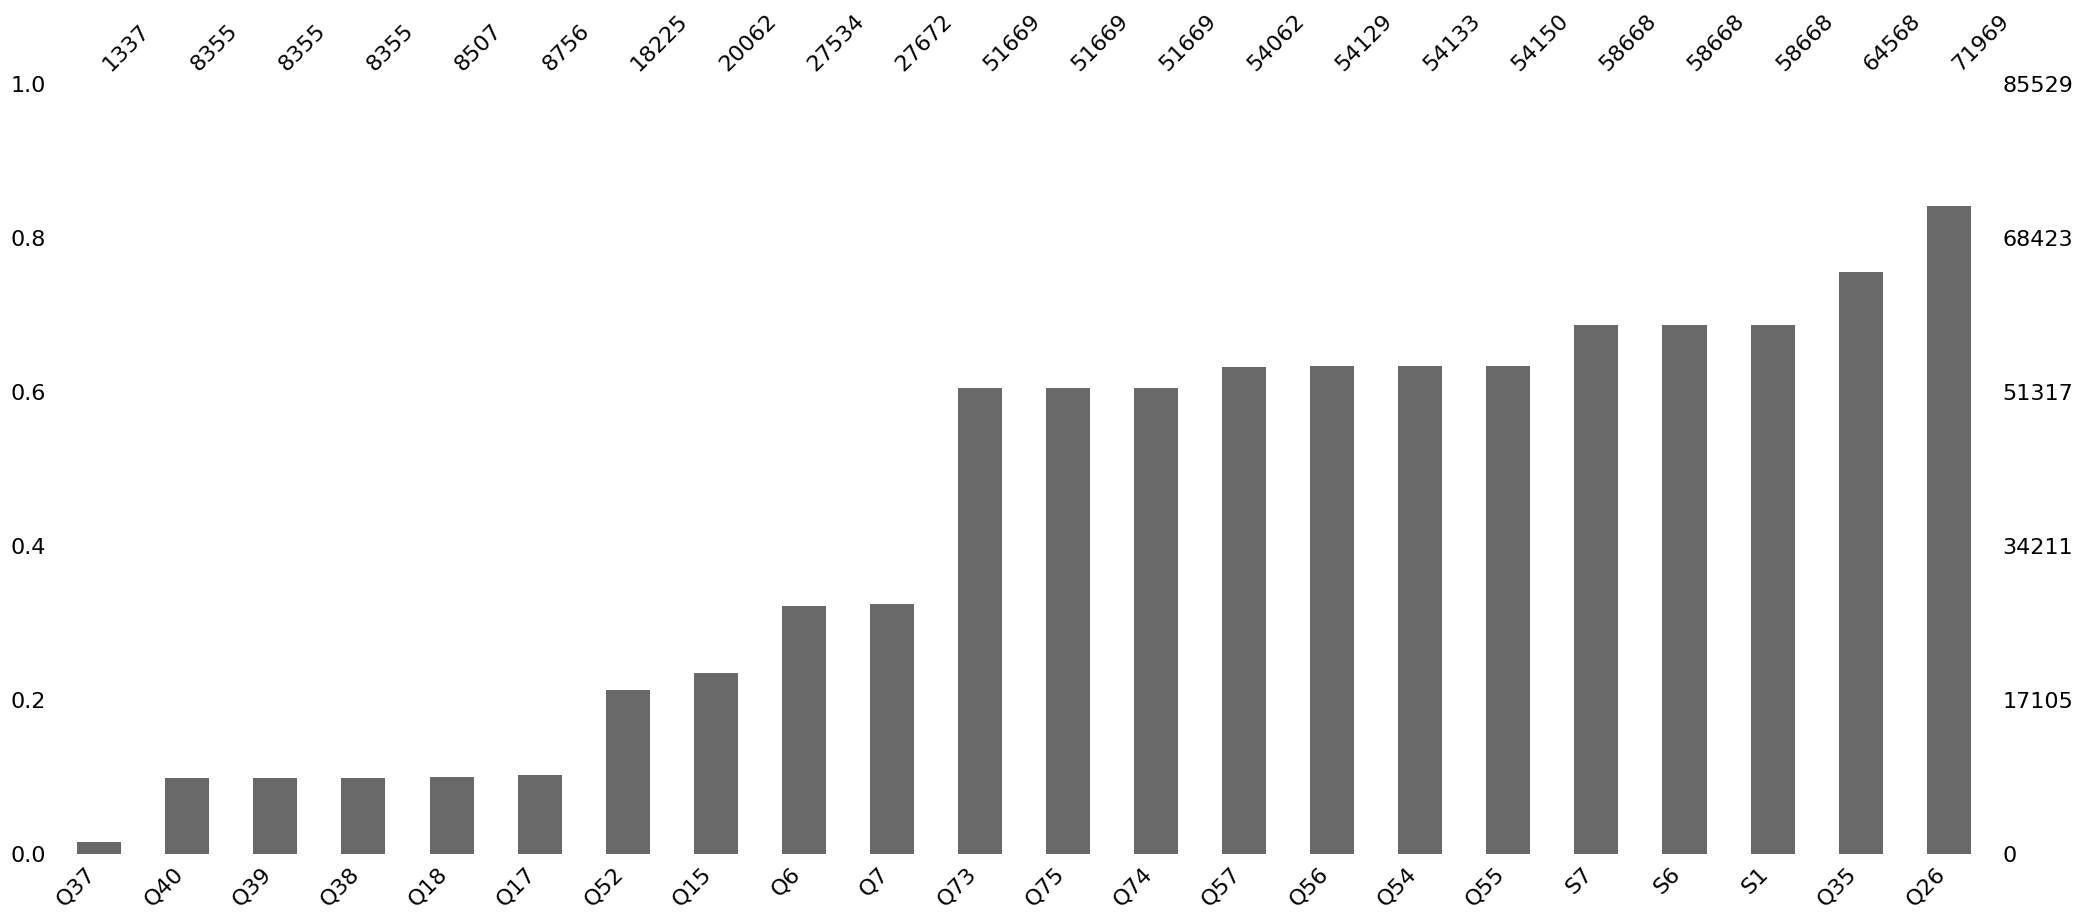

In [7]:
# Count no-missing.
msno.bar(elec_df, filter="bottom", p=0.9, sort="ascending");

In [8]:
# Nullity correlation matrix.
# msno.heatmap(elec_df, filter="bottom", p=0.9, sort="ascending");

* Variables marked with the prefix Q exhibit a higher susceptibility to missing values, as indicated by their ranking in descending order of missing rates on the x-axis of the heatmap presented above. Additionally, certain variables demonstrate a notable correlation in terms of nullity. For instance, the absence of values in Q38 consistently coincides with missing values in Q39 and Q40, suggesting a sequential relationship (Q38 -> Q39 -> Q40) with a decreasing rate of missing values. Similar patterns are observed in pairs such as Q17-Q18, Q73-Q75, and Q57-Q55. It's crucial to note that these variables are associated with the presence of electrical equipment in households, usage patterns, and occupancy periods. On the other side, the nullity of Q6-Q7 is inversely linked to that of Q55-Q57.
 
* Positive correlations can be attributed to common usage patterns, dependencies on equipment presence (complementary accessories), or links between occupancy and usage. Conversely, negative correlations, may indicate the presence of substitute equipment or variations in lifestyle.

> POSSIBLE SOLUTIONS
> 
> We might probably more likely consider only a subset of each group of variables based on their inter-correlation and their link with the target variable.
> * Delete columns with high missing rate (possibly after having created new feature using combination of transformation of existing ones).
> * Impute missing values during the training step of the modelling.
> * Use algorithms that are robust to or handle automatically missing value.

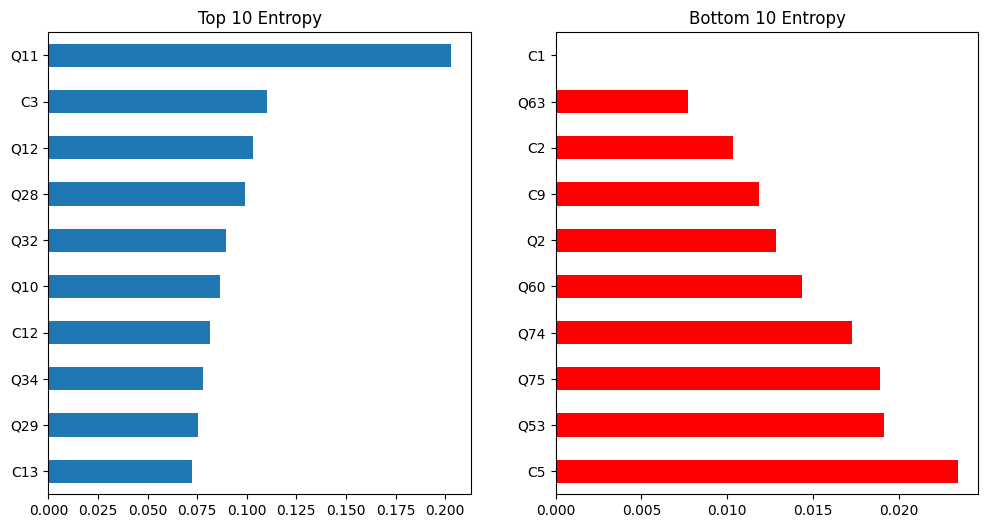

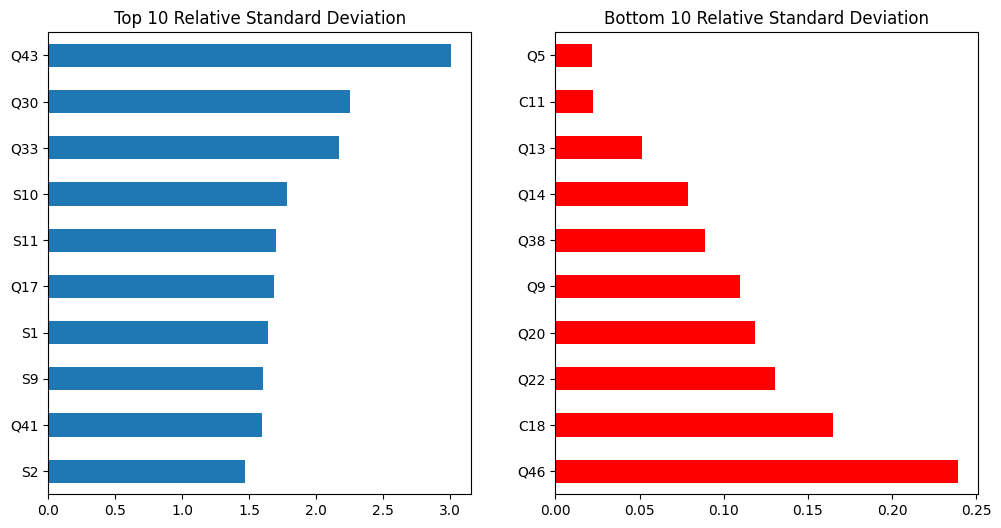

In [87]:
#TODO: Use it later (just before 1st features choices)
# Compute entropy for discrete variables and variance for continous variables.
# --> assess the quantity of information provided by each variable.
def entropy(column_series: pd.Series, normalize: bool=False) -> float:
    """Compute the entropy.

    Args:
        column_series (pd.Series): a series
        normalize (bool, optional): whether to normalize the entropy by 
            the number of class in the series. Defaults to False.

    Returns:
        float: entropy of the series
    """
    n_classes = len(column_series)
    if n_classes <= 1:
        return 0 
    
    # Compute frequencies then entropy.
    value_counts = column_series.value_counts(normalize=True)
    entropy = -np.sum(value_counts * np.log2(value_counts)) 
    
    if normalize:
        return entropy / np.log2(n_classes)
    return entropy

def compute_entropies(df: pd.DataFrame, normalize=False):
    categorical_columns = df.select_dtypes(include=["object", "string"]).columns
    other_binary_columns = df.select_dtypes("number").columns[df.select_dtypes("number").nunique() == 2]
    categorical_columns = categorical_columns.append(other_binary_columns) 
    entropies = {column: entropy(df[column], normalize=normalize) for column in categorical_columns}
    return entropies

# -----------------------------------
# ---- CATEGORICAL VARIABLES --------
# -----------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Compute entropies for all categorical variables.
entropy_series = pd.DataFrame.from_dict(compute_entropies(elec_df), orient="index")[0]
# entropy_series.sort_values().tail(20).plot(kind="barh", ax=axes[0])
# entropy_series.sort_values().head(20).plot(kind="barh", ax=axes[1])

relative_entropy_series = pd.DataFrame.from_dict(compute_entropies(elec_df, True), orient="index")[0]
relative_entropy_series.sort_values().tail(10).plot(kind="barh", title="Top 10 Entropy", ax=axes[0])
relative_entropy_series.sort_values(ascending=False).tail(10).plot(kind="barh", title="Bottom 10 Entropy", ax=axes[1], color="red")
plt.show()


# ---------------------------------
# ---- NUMERICAL VARIABLES --------
# ---------------------------------
# Relative coefficient.
other_binary_columns = elec_df.select_dtypes("number").columns[elec_df.select_dtypes("number").nunique() == 2]
number_columns = elec_df.select_dtypes("number").columns.difference(other_binary_columns)
variation_coefficient = elec_df[number_columns].std().sort_index() / elec_df[number_columns].mean().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
variation_coefficient.sort_values().tail(10).plot(kind="barh", title="Top 10 Relative Standard Deviation", ax=axes[0])
variation_coefficient.sort_values(ascending=False).tail(10).plot(kind="barh", title="Bottom 10 Relative Standard Deviation", ax=axes[1], color="red")
plt.show()

> * For the moment, we do not systematically remove variables with lower information (lower entropy for categorical or lower variance for numerical) because some of them might still be stronlgy correlated with the target variable (while being unrelated with the lower), giving them highly predictive power. Neverthless, considering this approach will assist us in choosing features from groups of correlated ones. (This analysis should be run again after removing outliers).

#### Low- and high-cardinality variables and Leakage variables

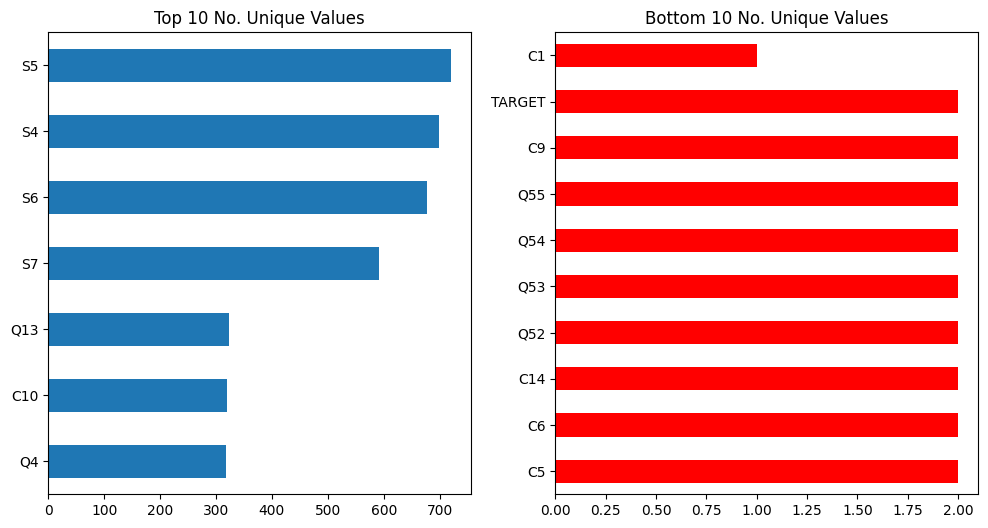

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Column cardinality (no. unique values per column).
cardinality_series = elec_df.nunique()
(
    cardinality_series.sort_values().tail(10)[:-3]
    .plot(kind="barh", title="Top 10 No. Unique Values", ax=axes[0])
)
(
    cardinality_series.sort_values(ascending=False).tail(10)
    .plot(kind="barh", title="Bottom 10 No. Unique Values", ax=axes[1], color="red")
 )
plt.show()

* "**ID**," as an identifier, is obviously a leakage variable. Here, we won't delve further, but one might consider a combination of variables that uniquely identify each line (coincidental relationship) that would need to be removed, if applicable. More generally, any categorical variables with "high" cardinality (compared to the sample size) would have lower variance. We would like to reduce the number of distinct categories, improve interpretability, or create more meaningful and manageable representations of the data.

* On the opposite side, "**C1**" has only one class (does not vary), rendering it useless for prediction (provides no information).

> **POSSIBLE SOLUTIONS**
> * Recode high-cardinality variables into a fewer number of classes (aggregation at higher-level).
>   * Particularly for `COD_INSEE`, we can explore a higher regional level (does it make sense? Perhaps, if electricity consumption behaviors are similar at the chosen level). Or group zone by zone (urban vs rural), size (big city vs small town) and geographical location (north, south, east, west).
> * Consider using `TargetEncoder`. `TargetEncoder` involves replacing each category of a variable with the average of the target variable in that category (e.g., replacing a region with the average consumption (here the proportion of people that have reduced their consumption)).
> * 
>
> **LIMITATIONS (contextual)**
> * Limited knowledge on variable: higher-level aggregation is less trivial for categorial variable -> use representativeness (keep most frequent classes and group all the others)


In [84]:
# Columns to drop.
todrop_columns = pd.Index(["ID", "C1"])
# Column to consider for recoding (those with more than 10 classes).
torecode_columns = cardinality_series[(cardinality_series > 10)].index.drop(todrop_columns, errors="ignore")
print(torecode_columns)

Index(['COD_INSEE', 'COD_IRIS', 'C10', 'C11', 'C15', 'C16', 'C17', 'C18',
       'C19', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
       'S11', 'S12', 'Q4', 'Q5', 'Q9', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
       'Q18', 'Q19', 'Q20', 'Q22', 'Q30', 'Q31', 'Q33', 'Q35', 'Q37', 'Q38',
       'Q40', 'Q48', 'Q51'],
      dtype='object')


In [11]:
# Save processed data.
elec_df.to_parquet(rf"{PROCESSED_DATA_PATH}/training_df_with_dtypes.parquet")

# Exploratory Data Analysis - Descriptive Statistics

- [ ] Potential bias issues (resource allocation or quality of service, qualitative assessement of sensitive features)
- [ ] univariate distribution (categorial, numerical)
- [ ] bivariate distribution (correlations, numerical vs numerical, categorial vs categorial, numerical vs categorial

#### Univariate distribution

In [12]:
# Numerical
elec_df.describe().T

,count,mean,min,25%,50%,75%,max,std
ID,85529.0,42764.0,0.0,21382.0,42764.0,64146.0,85528.0,24690.239924
COD_INSEE,83752.0,51426.064106,1001.0,31246.75,51525.0,75115.0,95690.0,26544.181516
COD_IRIS,83802.0,514334104.199518,10010000.0,312480000.0,515280000.0,751155814.0,956900000.0,265427659.353859
C5,85529.0,0.07498,0.0,0.0,0.0,0.0,1.0,0.263361
C6,85529.0,0.18105,0.0,0.0,0.0,0.0,1.0,0.385062
...,...,...,...,...,...,...,...,...
Q49,84692.0,1.525906,0.0,1.0,1.0,2.0,3.0,0.783068
Q50,84689.0,1.436137,0.0,1.0,1.0,2.0,3.0,0.751242
Q51,84757.0,1.090754,0.0,0.0,1.0,1.0,20.0,1.27601
Q52,18225.0,0.254156,0.0,0.0,0.0,1.0,1.0,0.435398


In [18]:
target = "TARGET"
sample_df = elec_df.sample(frac=0.25, replace=False, random_state=42)
num_cols = elec_df.select_dtypes("number").drop(columns=["COD_INSEE", "COD_IRIS"]).columns
select_num_cols = sample_df[num_cols].isna().sum()[(sample_df[num_cols].isna().sum() < 0.05 * len(sample_df))].index.drop("ID")
s_numcols_C = select_num_cols[select_num_cols.str.startswith("C")].insert(-1, target)
s_numcols_S = select_num_cols[select_num_cols.str.startswith("S")].insert(-1, target)
s_numcols_Q = select_num_cols[select_num_cols.str.startswith("Q")].insert(-1, target)
df = sample_df[select_num_cols].fillna(sample_df[select_num_cols].mean().astype(int))

df = df.astype(float)
# sns.pairplot(df[s_numcols_C], hue=target)

1
12


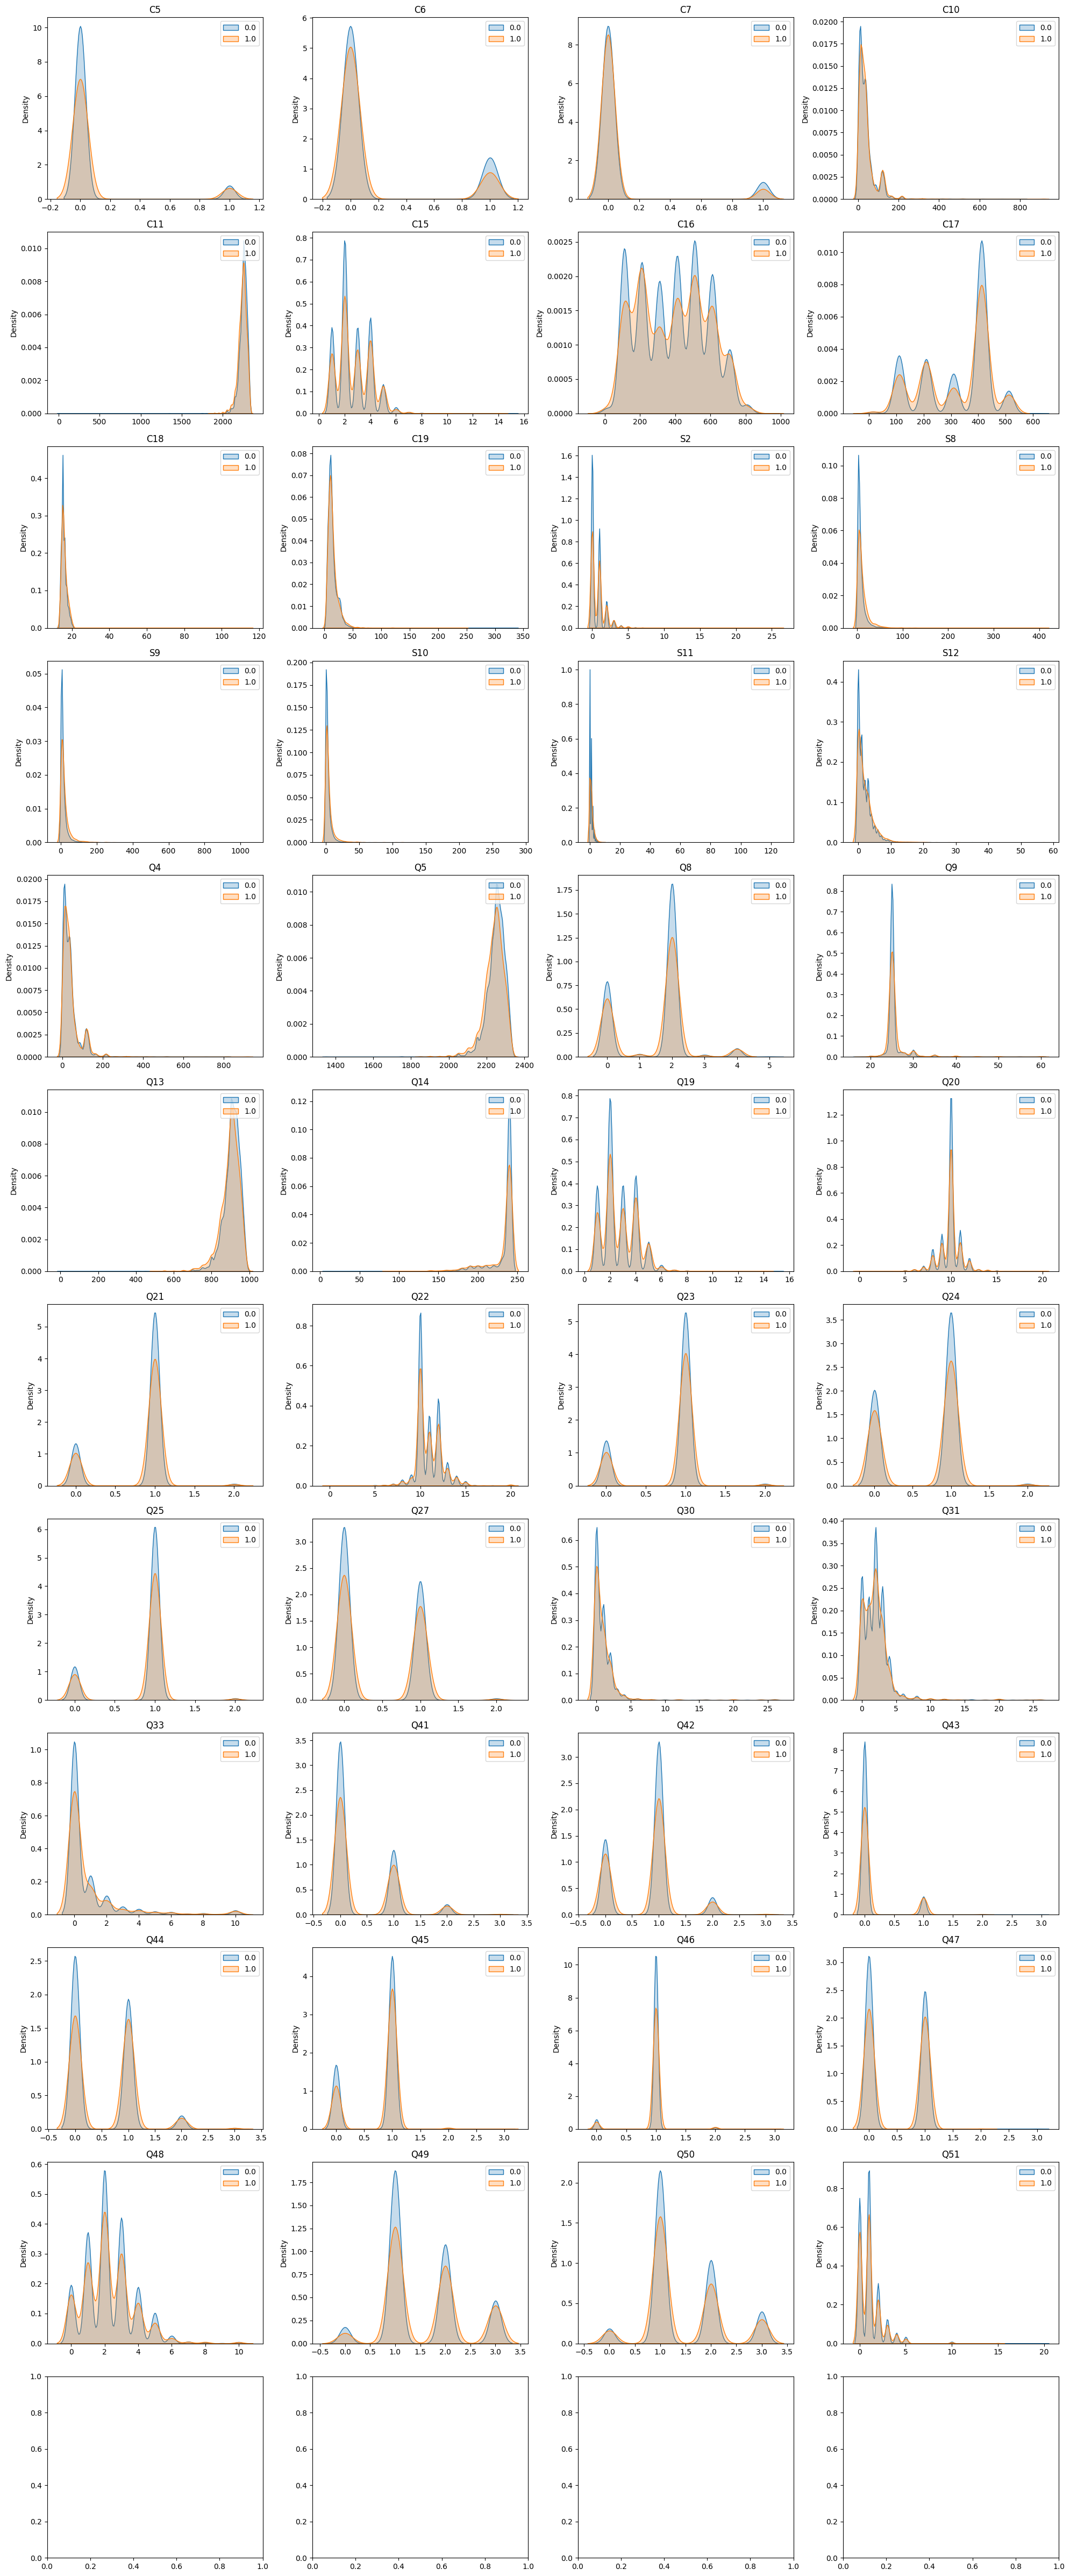

In [75]:
def plot_kde_grid(data, columns, grid_cols=3, hue=None):
    """
    Plot KDE plots for specified columns in a grid.

    Parameters:
    - data: DataFrame
    - columns: List of column names to plot
    - grid_cols: Number of columns in the grid
    - hue: Column name to use for color encoding

    Returns:
    - None (displays the grid of KDE plots)
    """
    # Calculate the number of rows needed in the grid
    grid_rows, reminder = divmod(len(columns) - (not hue), grid_cols)
    print(reminder)
    grid_rows += (reminder > 0)  # assess if there remain some columns
    # grid_rows = int(np.floor(len(columns) / grid_cols)) + 
    print(grid_rows)

    # Create a grid of subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(5 * grid_cols, 4 * grid_rows))
    axes = axes.flatten()

    # Loop through each column and plot KDE
    for i, column in enumerate(columns.drop(target)):
        ax = axes[i]
        if not hue:
            sns.kdeplot(data[column], ax=ax, fill=True)
        else:
            for hue_level in data[hue].unique():
                subset_data = data[data[hue] == hue_level]
                sns.kdeplot(subset_data[column], ax=ax, fill=True, label=f"{hue_level}", common_norm=False)

        ax.set_title(column)
        ax.set_xlabel('')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming df is your DataFrame and columns_to_plot is a list of column names
plot_kde_grid(df, select_num_cols, grid_cols=4, hue="TARGET")


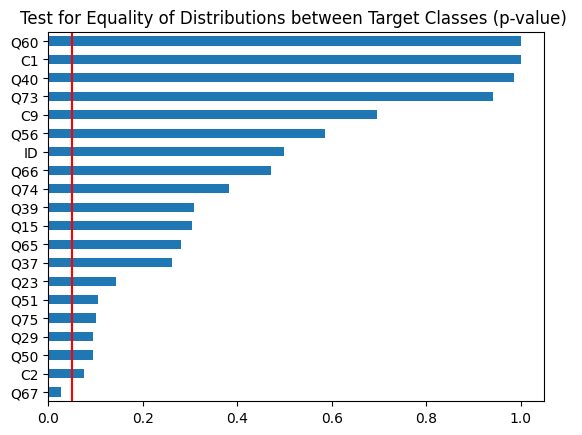

In [71]:
import pandas as pd
import scipy.stats as stats

def test_distribution_difference_all(data: pd.DataFrame, target_variable: str, feature_variables: List[str] | pd.Index):
    """
    Test the difference of distribution between two classes of a target variable for a list of feature variables.

    Parameters:
    - data: DataFrame
    - target_variable: Column name of the target variable (binary)
    - feature_variables: List of column names of feature variables

    Returns:
    - result_dict: Dictionary containing test statistics and p-values for each feature variable
    """
    result_dict = {
        feature: test_distribution_difference(data, target_variable, feature) if data[feature].dtype == ("O", "S") else
        test_distribution_difference_categorical(data, target_variable, feature) for feature in feature_variables.drop(target_variable)
    }

    # for feature in feature_variables:
    #     if data[feature].dtype == 'O':
    #         # Categorical variable
    #         chi2_stat, p_value = test_distribution_difference_categorical(data, target_variable, feature)
    #     else:
    #         # Continuous variable
    #         test_stat, p_value = test_distribution_difference(data, target_variable, feature)

    #     result_dict[feature] = [test_stat, p_value]

    return result_dict

def test_distribution_difference(data, target_variable, feature_variable, equal_var=False):
    """
    Test the difference of distribution between two classes of a target variable for a continuous feature variable.

    Parameters:
    - data: DataFrame
    - target_variable: Column name of the target variable (binary)
    - feature_variable: Column name of the continuous feature variable

    Returns:
    - test_statistic: Test statistic
    - p_value: p-value
    """
    class_0 = data[data[target_variable] == 0][feature_variable]
    class_1 = data[data[target_variable] == 1][feature_variable]

    # # Assuming the data is approximately normally distributed
    # test_statistic, p_value = stats.ttest_ind(class_0, class_1, equal_var=equal_var)

    # # Cramér-von Mises test
    # test_statistic, p_value = stats.cramervonmises(class_0, class_1)

    # Kolmogorov-Smirnov test
    test_statistic, p_value = stats.ks_2samp(class_0, class_1)

    return test_statistic, p_value

def test_distribution_difference_categorical(data, target_variable, categorical_variable):
    """
    Test the difference of distribution between two classes of a target variable for a categorical variable.

    Parameters:
    - data: DataFrame
    - target_variable: Column name of the target variable (binary)
    - categorical_variable: Column name of the categorical variable

    Returns:
    - chi2_statistic: Chi-squared statistic
    - p_value: p-value
    """
    contingency_table = pd.crosstab(data[target_variable], data[categorical_variable])
    chi2_statistic, p_value, _, _ = stats.chi2_contingency(contingency_table)

    return chi2_statistic, p_value


result_dict = test_distribution_difference_all(elec_df, target, elec_df.columns)
test_result_df = (
    pd.DataFrame.from_dict(result_dict, orient="index", columns=["statistics", "p_value"])["p_value"]
    .sort_values()
)
test_result_df.tail(20).plot(kind="barh", title="Test for Equality of Distributions between Target Classes (p-value) ")
plt.axvline(0.05, color="red")
plt.show()


In [95]:
todrop_columns_corrtest = test_result_df[test_result_df > 0.05].index
todrop_columns_corrtest 

Index(['C2', 'Q50', 'Q29', 'Q75', 'Q51', 'Q23', 'Q37', 'Q65', 'Q15', 'Q39',
       'Q74', 'Q66', 'ID', 'Q56', 'C9', 'Q73', 'Q40', 'C1', 'Q60'],
      dtype='object')

In [79]:
test_result_df.head(90)

Q34    0.000000
Q16    0.000000
Q10    0.000000
C3     0.000000
C4     0.000000
         ...   
Q21    0.010402
Q48    0.014564
Q18    0.016180
Q2     0.021632
Q67    0.027668
Name: p_value, Length: 90, dtype: float64

In [20]:
# Categorical
elec_df.describe(include="O").T

,count,unique,top,freq
C1,85529,1,EA,85529
C2,85529,4,RA,83692
C3,85529,9,B,34515
C4,85529,2,IB,64050
C8,85529,2,YB,57655
C9,85529,2,RA,82966
C12,85529,4,OB,52489
C13,85529,5,RC,64751
C14,85529,2,OB,58320
Q1,85529,4,HC,56943


In [ ]:
# 

# Modelling

- [ ] Define the task (type of problem, set target if at all, choose initial features)
- [ ] Check (again) the target (class imbalances)
- [ ] Set main metrics, validation strategy
- [ ] Train-Test split
- [ ] Feature engineering pipeline
- [ ] Baseline model
- [ ] Training, hyperparemeters tuning
- [ ] Features selection
- [ ] Evaluation
- [ ] Explaination

In [15]:
# 

# Communication

- [ ] Summarize results, model comparison
- [ ] Feature contribution
- [ ] Interactive Widget
- [ ] an App? (if it remains enough time)

In [16]:
#

## Recommendation

* Next-time, use a randomized trial with control and treated group (if the objective is to know the effectiveness of some recommendation program)  